## Agent-Based Monte-Carlo Simulation

We have an ant sitting in one corner of a cube wireframe.

The ant takes exactly 1 minute to crawl from one end of the wire to the other.  At each vertex of the cube, it has an equal probability of going down either one of the wires.

What is the probability distribution of the time it will take the ant to crawl from where it is to the vertex on the opposite end of the cube?

Here is what it looks like:  http://prntscr.com/80168r

A network.  The ant is sitting at Node 1 and needs to get to Node 8 following the routing rules at each node.

In [1]:
%matplotlib inline
import datetime
import random
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import igraph
from igraph import *

In [2]:
## Define the graph:
cube = Graph()
cube["date"] = datetime.date.today()
print cube
print cube["date"]

IGRAPH U--- 0 0 --
+ attr: date (g)
2015-08-06


In [3]:
cube.add_vertices(8)
print cube

IGRAPH U--- 8 0 --
+ attr: date (g)


In [4]:
cube.vs["beenthere"] = ("Now", "No", "No", "No", "No", "No", "No", "Endpoint")
print cube

IGRAPH U--- 8 0 --
+ attr: date (g), beenthere (v)


In [5]:
cube.add_edges ([(0,1),(0,5),(0,3), (1,6), (1,2),  (2,7), (2,3), (3,4), (4,5), (4,7), (5,6), (6,7)])
print cube

IGRAPH U--- 8 12 --
+ attr: date (g), beenthere (v)
+ edges:
0 -- 1 3 5   2 -- 1 3 7   4 -- 3 5 7   6 -- 1 5 7
1 -- 0 2 6   3 -- 0 2 4   5 -- 0 4 6   7 -- 2 4 6


In [6]:
cube.vs["name"] = ["1", "2", "3", "4", "5", "6", "7", "8"]
print cube
print cube.vs["beenthere"]

IGRAPH UN-- 8 12 --
+ attr: date (g), beenthere (v), name (v)
+ edges (vertex names):
1 -- 2, 4, 6   3 -- 2, 4, 8   5 -- 4, 6, 8   7 -- 2, 6, 8
2 -- 1, 3, 7   4 -- 1, 3, 5   6 -- 1, 5, 7   8 -- 3, 5, 7
['Now', 'No', 'No', 'No', 'No', 'No', 'No', 'Endpoint']


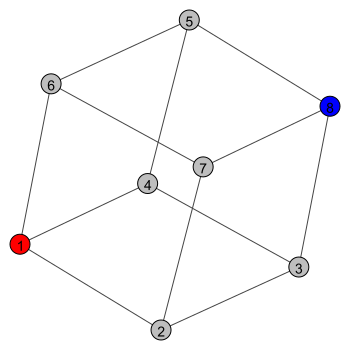

In [7]:
vx_color_dict = {"Now": "red", "No": "gray", "Endpoint": "blue"}

layout = cube.layout_auto()
visual_style = {}
visual_style["vertex_size"] = 20
visual_style["vertex_color"] =  [vx_color_dict[here] for here in cube.vs["beenthere"]]
visual_style["vertex_label"] = cube.vs["name"]
visual_style["layout"] = layout
visual_style["bbox"] = (350, 350)
visual_style["margin"] = 20
plot(cube,  **visual_style)

The ant needs to crawl from Node 1 (red) to Node 8 (blue) with 1/cube.degree() probability of choosing each of the edges at each of the vertices.


In [8]:
route_prob = [1.0/dgr for dgr in cube.degree()]
print cube.degree()
print route_prob

[3, 3, 3, 3, 3, 3, 3, 3]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


Now let's create our ***ant*** class.

It will have 2 **methods**: *update()* and *decide()*.  
It will also have to know which three edges it is choosing from.  We will call the class carrying this information ***state***

The ***state*** class will keep track of the graph and the current node ID

In [9]:
## Let's first see how edges are represented in igraph:
print cube.es.indices
all_edges = cube.get_edgelist()
print all_edges
edge = all_edges[0]
print edge
print edge[0], edge[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[(0, 1), (0, 5), (0, 3), (1, 6), (1, 2), (2, 7), (2, 3), (3, 4), (4, 5), (4, 7), (5, 6), (6, 7)]
(0, 1)
0 1


In [10]:
##  Now we can define the class State
class State:
    node_id = 0
    wires = []
    probs = []
    graph = None
    
    # The second argument we pass during initialization is the graph of the environment (cube)
    def __init__ (self, node_id, g):
        self.node_id = node_id
        self.graph = g.copy()
        self.update()
        
    def update(self, node_id = node_id):
        ##  Assign the new node_id
        self.node_id = node_id
        self.getMyNewWires()
        self.getProbabilities()
       
    ''' We can later build a derived class from here
    with a different getProbabilities() function'''
    def getProbabilities (self):
        if len (self.wires) == 0:
            self.getMyNewWires()
        self.probs = 1.0 / len (self.wires)
    
    def getMyNewWires(self):
        mywires = self.wires
       
        if len(mywires) > 0:
            del mywires
            mywires = []
            
        all_edges = self.graph.get_edgelist()
        #  print "all edges of the graph:", all_edges
        for ii in self.graph.es.indices:
            edge = all_edges[ii]
            # print "Edge", edge
            if edge[0] == self.node_id or edge[1] == self.node_id:
                # print "Adding edge ", edge, " to wires"
                mywires.append (edge)
        self.wires = mywires    
        
###   Testing the class:     
myState = State (0, cube)
print "node ID %d" %(myState.node_id)
print "My edges:", myState.wires     
print "My edge probabilities:", myState.probs

print ""
## Moving the ant to the next node:
myState.update (1)
print "node ID %d" %(myState.node_id)
#The getMyNewWires() is already done in the update() function
print "My edges:", myState.wires     
print "My edge probabilities:", myState.probs

node ID 0
My edges: [(0, 1), (0, 5), (0, 3)]
My edge probabilities: 0.333333333333

node ID 1
My edges: [(0, 1), (1, 6), (1, 2)]
My edge probabilities: 0.333333333333


Now that we have the ***State*** class defined, working, and instantiated, we can define the ***Ant***

In [12]:
myInitState = State (0, cube)
print "node ID %d" %(myInitState.node_id)
print "My edges:", myInitState.wires     
print "My edge probabilities:", myInitState.probs
print "My vertices:", myInitState.graph.vs["beenthere"]


node ID 0
My edges: [(0, 1), (0, 5), (0, 3)]
My edge probabilities: 0.333333333333
My vertices: ['Now', 'No', 'No', 'No', 'No', 'No', 'No', 'Endpoint']


In [13]:
class Ant:
    state = None
    arrived_TF = False
    
    def __init__ (self, mystate):
        self.state = mystate
        
    ## This is the most basic way of selecting random routes: 
    ## We don't need to build an actual distribution; so we will just pick 
    ## at random out of the 3 possibilities (bootstrapping)''' 
    def decide (self):
        myNextEdge = random.randrange (0, len (self.state.wires))
        print self.state.wires[myNextEdge]
        return myNextEdge
    
    def update(self):
        myNextEdge = self.decide()
        # we choose the next node_id where the ant is not (the ant never stays on the same node):
        whichway = 0
        if self.state.node_id == self.state.wires[myNextEdge][whichway]: 
            whichway = 1
            
        #print self.state.node_id, self.state.wires[myNextEdge], self.state.wires[myNextEdge][whichway]
        myNewNodeID = self.state.wires[myNextEdge][whichway]
        self.state.update(myNewNodeID)
        if self.state.graph.vs[myNewNodeID]["beenthere"] == "Endpoint":
            print "Arrived"
            self.arrived_TF = True
        else:
            self.state.graph.vs[myNewNodeID]["beenthere"] = "Now"
            

ant = Ant(myInitState)
print "Created an ant in the following state:"
print "Current node ID %d" %(ant.state.node_id)
print "Possible routes:", ant.state.wires     
print "Decision Probabilities:", ant.state.probs
print ant.state.graph.vs["beenthere"]

print ""

Created an ant in the following state:
Current node ID 0
Possible routes: [(0, 1), (0, 5), (0, 3)]
Decision Probabilities: 0.333333333333
['Now', 'No', 'No', 'No', 'No', 'No', 'No', 'Endpoint']



In [30]:
myInitState = State (0, cube)
print "node ID %d" %(myInitState.node_id)
print "My edges:", myInitState.wires     
print "My edge probabilities:", myInitState.probs
print "My vertices:", myInitState.graph.vs["beenthere"]


node ID 0
My edges: [(0, 1), (0, 5), (0, 3)]
My edge probabilities: 0.333333333333
My vertices: ['Now', 'No', 'No', 'No', 'No', 'No', 'No', 'Endpoint']


Now we will iterate through the Ant.update() method until we arrive and increment the counter in the process.  If after 1000 iterations we are still not at the endpoint, we will stop the simulation.

In [31]:
ant = Ant(myInitState)
print "Created an ant in the following state:"
print "Current node ID %d" %(ant.state.node_id)
print "Possible routes:", ant.state.wires     
print ant.state.graph.vs["beenthere"]

iter_counter = 0
for ii in range (1000):
    ant.update()
    ##  Update the global state - absolutely necessary when running multiple ant agents
    myInitState.update(ant.state.node_id)
    print "Updated the ant to the following state:"
    print "Current node ID %d" %(ant.state.node_id)
    print "Possible routes:", ant.state.wires     
    print ant.state.graph.vs["beenthere"]
    iter_counter = ii
    if ant.arrived_TF:
        break

print "Completed %d iterations." % iter_counter
print "Arrived = ", ant.arrived_TF

Created an ant in the following state:
Current node ID 0
Possible routes: [(0, 1), (0, 5), (0, 3)]
['Now', 'No', 'No', 'No', 'No', 'No', 'No', 'Endpoint']
(0, 1)
Updated the ant to the following state:
Current node ID 1
Possible routes: [(0, 1), (1, 6), (1, 2)]
['Now', 'Now', 'No', 'No', 'No', 'No', 'No', 'Endpoint']
(0, 1)
Updated the ant to the following state:
Current node ID 0
Possible routes: [(0, 1), (0, 5), (0, 3)]
['Now', 'Now', 'No', 'No', 'No', 'No', 'No', 'Endpoint']
(0, 3)
Updated the ant to the following state:
Current node ID 3
Possible routes: [(0, 3), (2, 3), (3, 4)]
['Now', 'Now', 'No', 'Now', 'No', 'No', 'No', 'Endpoint']
(0, 3)
Updated the ant to the following state:
Current node ID 0
Possible routes: [(0, 1), (0, 5), (0, 3)]
['Now', 'Now', 'No', 'Now', 'No', 'No', 'No', 'Endpoint']
(0, 1)
Updated the ant to the following state:
Current node ID 1
Possible routes: [(0, 1), (1, 6), (1, 2)]
['Now', 'Now', 'No', 'Now', 'No', 'No', 'No', 'Endpoint']
(0, 1)
Updated the ant

This has been the general illustration of the two most powerful concepts in analytics from the 20th and 21st centuries:

###Monte-Carlo simulation

###Agent-Based simulation

Because we intentionally did not set the seed, each time we rerun the simulation, we will have different numbers of iterations.  With enough simulations (same idea as we used for random forest and other cross-validation techniques), we will converge to the estimate of the true number of minutes the ant will take to arrive.